# Comparison of Adjacent TMA sections and Single versus Standard IF

**Visualization:** Multi-color overlays automatically generated.

**Samples:** 
- Cyclic and standard IF adjacent sections
- Adjacent sections of HER2 + TMA

**Method**: Often images in publications are not reproducible: the ROI selected and the display range are not documented. This code allows for fully reproducible visualizations of image data.

In [2]:
#libraries
import os
import pandas as pd
import numpy as np
from mplex_image import preprocess, process, analyze, mpimage, cmif
import subprocess
from itertools import compress
import shutil
import importlib
import skimage
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
#important paths
codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies'
figdir = f'{codedir}/Figures'
preprocess.cmif_mkdir([figdir])

In [4]:
%matplotlib inline

# Figure 1: Visualization of single vs cycIF

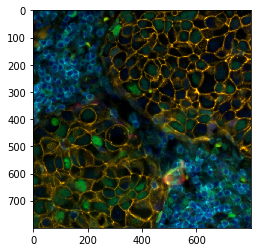

In [5]:
#single vs cyclic

#cropping coordinates
d_crop = {'44290-112':(5100,8900),
 '44290-113':(6030,8211),
 '44290-114':(5210,9242),
 '44290-115':(6250,10590),
 '44290-116':(6636,9274),
 '44294-116':(9947,5959),
 '44294-117':(12480,6592),
 '44294-118':(11301, 6882),
 '44294-119':(10253,5857),
 '44294-120':(10450,5810),
 }

d_process = {
    '44290':f'{codedir}/Images/tiff/44290',
 }
#load image and exposure time dataframe
df_img = pd.read_csv(f'{codedir}/Metadata/44290/SNR_single_vs_cyclic.csv',index_col=0)
df_img.index = [item.replace('20191104_ValidationStudies','cycIF_ValidationStudies') for item in df_img.index]
df_img['experimenttype'] = [item.split('_')[2] for item in df_img.condition] 
df_img['experiment'] = [item.split('_')[0] for item in df_img.condition] 
df_img['singlerounds'] = [item.split('_')[1] for item in df_img.condition] 
df_img['scene'] = df_img.slide

for idx,(s_sample, s_path) in enumerate(d_process.items()):
    preprocess.cmif_mkdir([f'{figdir}/{s_sample}'])
    os.chdir(s_path)
    df_dapi = mpimage.parse_org()
    df_dapi = df_dapi[df_dapi.color=='c1']
    df_img['path'] = [f'{s_path}/{item}' for item in df_img.index]
    df_dapi['path'] = [f'{s_path}/{item}' for item in df_dapi.index]
    #make multicolor png for figure 1 (800x800 pixel)
    d_overlay = {'R2':[ 'PCNA','Her2','ER','CD45'],
     'R3':['pH3', 'CK14', 'CD44', 'CK5'],
     'R4':[ 'Vim', 'CK7', 'PD1', 'LaminAC',],
     'R5':['aSMA', 'CD68', 'Ki67', 'Ecad'],
     }
    
    for s_tissue in ['tumor','normal']:
        if s_tissue == 'tumor':
            es_dim = {'nada'}
            es_bright={'pH3','CK14','CK5'}
        else:
            es_dim = {'nada'}
            es_bright={'Ki67','pH3'}
        df_tissue = df_img[(df_img.experimenttype==s_tissue) & (df_img.rounds!='R6')]
        for s_type in ['single','cyclic']: 
            df_type = df_tissue[df_tissue.experiment==s_type]
            for s_round in ['R2','R3','R4','R5']:
                if s_type == 'single':
                    df_round = df_type[df_type.singlerounds==s_round]
                else:
                    df_round = df_type[df_type.rounds==s_round]
                s_slide = df_round.slide[0]
                df_dapi_round = df_dapi[(df_dapi.scene==s_slide) & (df_dapi.rounds=='R5') & (df_dapi.color=='c1')]
                if df_type.scene[0] == '44294-116':
                        df_dapi_round = df_dapi[(df_dapi.scene==s_slide) & (df_dapi.rounds=='R4') & (df_dapi.color=='c1')]
                else:
                        df_dapi_round = df_dapi[(df_dapi.scene==s_slide) & (df_dapi.rounds==s_round) & (df_dapi.color=='c1')]

                high_thresh=0.999
                d_overlay_round = {s_round:d_overlay[s_round]}
                d_result = mpimage.multicolor_png(df_round,df_dapi,s_scene=df_round.scene[0],d_overlay=d_overlay_round,d_crop=d_crop,es_dim=es_dim,es_bright=es_bright,low_thresh=1000,high_thresh=high_thresh)
                for key, tu_result in d_result.items():
                    skimage.io.imsave(f'{figdir}/{s_sample}/ColorArray_{df_round.scene[0]}_{key}_{".".join(tu_result[0])}.png',tu_result[1])
                    if key == 'R2':
                        if s_tissue == 'tumor':
                            plt.imshow(tu_result[1])


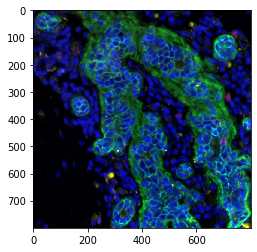

In [5]:
plt.imshow(tu_result[1])

# Figure 3 a-b: TMA replicates

/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/exacloud/tempwork/Chin_Lab/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


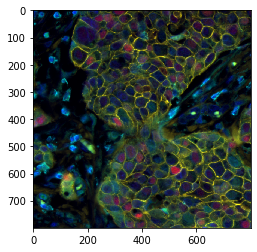

In [6]:
#replicate

df_img_all = pd.read_csv(f'{codedir}/Metadata/BM-Her2N75/SNR_jenny_replicates.csv',index_col=0)
df_img_all.index = [item.replace('20191104_ValidationStudies','cycIF_ValidationStudies') for item in df_img_all.index]
df_img_all['slide'] = [item.split('-Scene-')[0] for item in df_img_all.tissue]
df_img_all['scene'] = [item.split('-Scene-0')[1] for item in df_img_all.tissue]

#20200423 make multicolor png for figure 3 (800x800 pixel)
d_overlay = {'R1':['CD20','CD8','CD4','CK19'],
    'R2':[ 'PCNA','Her2','ER','CD45'],
     'R3':['pH3', 'CK14', 'CD44', 'CK5'],
     'R4':[ 'Vim', 'CK7', 'PD1', 'LaminAC',],
     'R5':['aSMA', 'CD68', 'Ki67', 'Ecad'],
     }

d_crop ={
    'BM-Her2N75-15-Scene-059':(2060,4000),
    'BM-Her2N75-17-Scene-059':(2049,4530),
    'BM-Her2N75-18-Scene-059':(3100,3760),
    'BM-Her2N75-15-Scene-017':(2260,2500),
    'BM-Her2N75-17-Scene-017':(2107,2795),
    'BM-Her2N75-18-Scene-017':(3189,3982),
    'BM-Her2N75-15-Scene-049':(3866,3379),
    'BM-Her2N75-17-Scene-049':(3809,3797),
    'BM-Her2N75-18-Scene-049':(2948,3099),
  }

for s_scene in ['17','49','59']: 
    if s_scene == '59':
        es_bright = {'CK14','CK5','pH3','CD68','ER'}
    else:
        es_bright = {'pH3','CD68','CK14','CK5'}
    df_scene = df_img_all[(df_img_all.scene==s_scene)]
    for s_sample in ['BM-Her2N75-18','BM-Her2N75-17','BM-Her2N75-15']:
        s_path = f'{codedir}/Images/tiff/{s_sample}'
        os.chdir(s_path)
        df_dapi = mpimage.parse_org()
        df_dapi = df_dapi[df_dapi.color=='c1']
        df_dapi['path'] = [f'{s_path}/{item}' for item in df_dapi.index]
        preprocess.cmif_mkdir([f'{figdir}/{s_sample}'])
        df_slide = df_scene[df_scene.slide==s_sample]
        df_slide['path'] = df_slide.index
        for s_round in ['R1','R5','R2','R3','R4']:
            df_round = df_slide[df_slide.rounds==s_round]
            s_slide_scene = f'{s_sample}-Scene-0{s_scene}'
            df_round['scene'] = s_slide_scene
            df_dapi_round = df_dapi[(df_dapi.rounds==s_round) & (df_dapi.scene == s_slide_scene)]
            high_thresh=0.999
            d_overlay_round = {s_round:d_overlay[s_round]}
            d_result = mpimage.multicolor_png(df_round,df_dapi_round,s_scene=s_slide_scene,d_overlay=d_overlay_round,d_crop=d_crop,es_dim={'nada'},es_bright=es_bright,low_thresh=2000,high_thresh=high_thresh)
            for key, tu_result in d_result.items():
                skimage.io.imsave(f'{figdir}/{s_sample}/ColorArray_{s_slide_scene}_{key}_{".".join(tu_result[0])}.png',tu_result[1])
                if key == 'R2':
                    if s_scene == '49':
                        plt.imshow(tu_result[1])


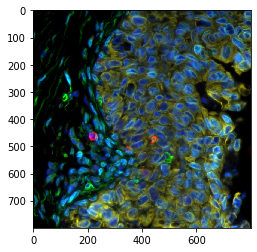

In [7]:
plt.imshow(tu_result[1])